In [2]:
library(Seurat)
library(tidyverse)
library(foreach)
library(doParallel)
library(ggplot2)
library(ggpubr)

Loading required package: SeuratObject

Loading required package: sp

'SeuratObject' was built with package 'Matrix' 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall 'SeuratObject' as
the ABI for 'Matrix' may have changed


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Warning m

In [3]:
esc.AS <- readRDS("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/RDS/esc_AS_remove_neg_904.rds")
esc.AS <- FindNeighbors(esc.AS, reduction = "pca",dims = 1:35) %>% FindClusters(resolution = 7, verbose = FALSE)
metadata <- esc.AS@meta.data %>% filter(cellname != "d3A74") %>% mutate(mc_cluster = SCT_snn_res.7)

Computing nearest neighbor graph

Computing SNN



In [3]:
esc.mc <- readRDS("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/esc_mc.rds")
esc.c5 <- readRDS('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/c5_153_marker_gene.rds')

In [4]:
esc.mc 

An object of class Seurat 
1661 features across 34 samples within 2 assays 
Active assay: SCT (742 features, 742 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [5]:
esc.c5

An object of class Seurat 
1015 features across 306 samples within 2 assays 
Active assay: SCT (403 features, 403 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [6]:
# FindVariableFeatures(esc.mc) -> esc.mc 
# gene_consider <- VariableFeatures(esc.mc)

FindVariableFeatures(esc.c5) -> esc.c5
gene_consider <- VariableFeatures(esc.c5)
gene_consider <- paste0('B6-',gene_consider)

In [7]:
gene_consider %>% length

[1] 403

In [8]:
FindVariableFeatures(esc.mc) -> esc.mc
esc.mc %>% NormalizeData() %>% ScaleData(do.center=T,do.scale=T) %>% RunPCA(verbose = F,features = VariableFeatures(esc.mc),npcs = 20,reduction.name = "mcsct_pca") -> esc.mc

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
Warning message:
"Key 'PC_' taken, using 'mcsctpca_' instead"


In [9]:
gene_info <- gene_consider %>% as.data.frame()
names(gene_info) <- "as_gene"
gene_info

as_gene
<chr>
B6-Gpc3
B6-Arhgap6
B6-Klhl13
B6-Amot
B6-Mid1
B6-Eda
B6-Shroom4
B6-Xist
B6-Gpc4


# Gene info

In [10]:
options(scipen = 999)

In [11]:
genes <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = FALSE)
names(genes) <- c("chrom","start","end","id","name","strand")
genes <- genes %>% mutate(length = end - start) %>% arrange(desc(length)) %>% group_by(name) %>% slice(1) %>% ungroup() %>% arrange(chrom, start) %>% select(-length)
genes <- genes %>% filter(chrom == "chrX")

Rows: 55335 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (4): X1, X4, X5, X6
dbl (2): X2, X3

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
bin_width <- 20000
genes <- genes %>% 
  mutate(start_bin = bin_width * floor(start / bin_width) - bin_width*25, 
         end_bin = bin_width * floor(end / bin_width) + bin_width*25)
genes <- genes %>% mutate(pos = paste0(start_bin,"_",end_bin))
head(genes)

chrom,start,end,id,name,strand,start_bin,end_bin,pos
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
chrX,3076874,3078817,ENSMUSG00000100249.1,Btbd35f23,+,2560000,3560000,2560000_3560000
chrX,3193886,3195827,ENSMUSG00000096426.2,Btbd35f24,-,2680000,3680000,2680000_3680000
chrX,3225599,3230364,ENSMUSG00000084298.1,Gm14331,+,2720000,3720000,2720000_3720000
chrX,3231694,3231958,ENSMUSG00000095907.2,Gm14333,-,2720000,3720000,2720000_3720000
chrX,3276855,3278543,ENSMUSG00000080876.3,Gm14332,-,2760000,3760000,2760000_3760000
chrX,3328042,3328735,ENSMUSG00000083144.1,Gm14334,+,2820000,3820000,2820000_3820000


In [13]:
gene_bins <- genes %>% select(name,start_bin,end_bin) %>% distinct() %>% arrange(name,start_bin)
gene_bins

name,start_bin,end_bin
<chr>,<dbl>,<dbl>
1110012L19Rik,69880000,70880000
1600025M17Rik,55800000,56820000
1700003E24Rik,92640000,93640000
1700010D01Rik,95220000,96220000
1700011M02Rik,102400000,103400000
1700013H16Rik,53240000,54240000
1700018G05Rik,102420000,103420000
1700020N15Rik,69440000,70440000
1700031F05Rik,102340000,103360000


In [14]:
split_gene_bins <- function(gene, start_bin, end_bin, res = 20000) {
  sequence <- seq(start_bin, end_bin, by = res)
  pair_list <- lapply(1:(length(sequence)-1), function(i) c(sequence[i], sequence[i+1]))
  start1 <- sapply(pair_list, "[", 1)
  end1 <- sapply(pair_list, "[", 2)
  genes <- rep(gene, length(start1))
  matrix <- cbind(genes, start1, end1)
}

In [15]:
gene_bins_split <- do.call(rbind, apply(gene_bins, 1, function(x) split_gene_bins(x[1], x[2], x[3]))) %>% as_tibble()

# DI dynamic data

In [17]:
DI <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c5_B6_XCI_diff.csv") %>% filter(FDR < 0.05) %>% filter(stats < 0.5*153*153)
DI["x"] <- DI$start1/20000
DI["y"] <- DI$start2/20000

New names:
* `` -> `...1`
Rows: 1690500 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
dim(DI)

[1] 188991     14

In [19]:
index <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/dynamic_data/index_c5_down.csv") %>% mutate(temp = paste0(index1,"-",index2)) %>% select(-"...1")
index$index_1D <- as.character(index$index_1D)

New names:
* `` -> `...1`
Rows: 188991 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (4): ...1, index1, index2, index_1D

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [20]:
head(index)

index1,index2,index_1D,temp
<dbl>,<dbl>,<chr>,<chr>
275,295,171125,275-295
275,296,179657,275-296
275,297,188188,275-297
275,298,196718,275-298
275,299,205247,275-299
275,300,213775,275-300


In [21]:
DI_dynamic <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/dynamic_data/DI_dynamic_c5_down.csv") %>% column_to_rownames("...1")

New names:
* `` -> `...1`
Rows: 188991 Columns: 905
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
metadata_mc <- esc.mc@meta.data

In [23]:
metadata_mc <- metadata_mc %>% filter(!is.na(time1))

In [25]:
index_of_mc <- metadata_mc %>% as.data.frame %>% pull(mc_cluster) %>% unique()
for(i in index_of_mc){
    print(i)
    if(i==index_of_mc[1]){
        cellname_sel <- metadata %>% filter(mc_cluster == i) %>% pull(cellname)
        DI_dynamic_mc <- DI_dynamic[cellname_sel] %>% rowMeans() %>% as.data.frame %>% rownames_to_column("DI_pos")
        names(DI_dynamic_mc) <- c("DI_pos",paste0("mc_",i))
    }else{
        cellname_sel <- metadata %>% filter(mc_cluster == i) %>% pull(cellname)
        temp <- DI_dynamic[cellname_sel] %>% rowMeans() %>% as.data.frame %>% rownames_to_column("DI_pos")
        names(temp) <- c("DI_pos",paste0("mc_",i))
        DI_dynamic_mc <- left_join(DI_dynamic_mc, temp, by = "DI_pos")
    }
}

[1] "0"
[1] "2"
[1] "16"
[1] "12"
[1] "7"
[1] "1"
[1] "23"
[1] "15"
[1] "9"
[1] "22"
[1] "33"
[1] "29"
[1] "21"
[1] "14"
[1] "19"
[1] "13"
[1] "20"
[1] "17"
[1] "10"
[1] "26"
[1] "27"
[1] "11"
[1] "18"
[1] "6"
[1] "25"
[1] "31"
[1] "5"
[1] "32"
[1] "30"
[1] "28"
[1] "24"


# start

In [26]:
esc.mc

An object of class Seurat 
1661 features across 34 samples within 2 assays 
Active assay: SCT (742 features, 742 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, mcsct_pca

In [28]:
sctRNAmat <- GetAssayData(object = esc.mc, assay = "RNA", slot = "counts") %>% as.matrix() %>% t()
sctRNAmat_temp <- sctRNAmat[,intersect(colnames(sctRNAmat),gene_consider)]

Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
i Please use the `layer` argument instead."


In [29]:
intersect(colnames(sctRNAmat),gene_consider) %>% length()

[1] 371

In [30]:
colnames(sctRNAmat_temp) %>% unique() %>% length()

[1] 371

In [37]:
DI_dynamic_mc <- DI_dynamic_mc %>% left_join(index %>% select(-temp), by = c("DI_pos" = "index_1D"))

In [38]:
DI_dynamic_mc <- DI_dynamic_mc %>% mutate(pos=paste0(index1,"_",index2)) %>% mutate(index1=index1*20000,index2=index2*20000) %>% select(-DI_pos) 

In [39]:
gene_bins_split <- gene_bins_split %>% mutate(as_gene_name = paste0("B6-", genes)) %>% filter(as_gene_name %in% gene_consider[gene_consider %>% grep("^B6-",.)])

In [41]:
DI_dynamic_mc <- DI_dynamic_mc %>% filter(index1 %in% gene_bins_split$start1 | index2 %in% gene_bins_split$start1)

In [42]:
di_link_gene <- DI_dynamic_mc %>% select(index1,index2,pos)

In [43]:
DI_dynamic_mc <- DI_dynamic_mc %>% select(-index1,-index2) %>% column_to_rownames("pos")

In [44]:
di_link_gene$gene_x <- NA
di_link_gene$gene_y <- NA
for (i in 1:nrow(di_link_gene)) {
  x_match_genes <- gene_bins_split$genes[gene_bins_split$start1 == di_link_gene$index1[i]]
  y_match_genes <- gene_bins_split$genes[gene_bins_split$start1 == di_link_gene$index2[i]]
  
  if (length(x_match_genes) > 0) {
    di_link_gene$gene_x[i] <- paste(x_match_genes, collapse = ", ")
  }
  
  if (length(y_match_genes) > 0) {
    di_link_gene$gene_y[i] <- paste(y_match_genes, collapse = ", ")
  }
}

In [45]:
di_link_gene <- di_link_gene %>%
  mutate(gene = coalesce(gene_x, gene_y)) %>%
  select(-gene_x, -gene_y)

In [46]:
di_link_gene <- di_link_gene %>% separate_rows(gene, sep = ",\\s*")

In [47]:
di_link_gene <- di_link_gene %>% mutate(gene = paste0("B6-",gene)) %>% arrange(gene)

In [48]:
di_link_gene <- di_link_gene %>% filter(gene %in% colnames(sctRNAmat_temp))

In [49]:
genes %>% filter(name=="Firre")

chrom,start,end,id,name,strand,start_bin,end_bin,pos
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
chrX,50555743,50635321,ENSMUSG00000085396.7,Firre,-,50040000,51120000,50040000_51120000


In [50]:
sctRNAmat_temp <- sctRNAmat_temp %>% as.data.frame() %>% select(colnames(sctRNAmat_temp) %>% sort())

In [51]:
sctRNAmat_temp <- sctRNAmat_temp[metadata_mc %>% pull(cellname),]

In [52]:
DI_dynamic_mc <- DI_dynamic_mc %>% t() %>% as.data.frame()

In [53]:
# DI_dynamic_mc %>% rownames_to_column("metacell") %>% write_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1218/HiC_analysis/DI/GADI/DI_dynamic_mc.csv",col_names = T)

# GADI

In [54]:
cor_test_wrapper <- function(gene,pos,x,y,method = "normal"){
    res <- tryCatch({
        if(method == "normal"){
            res <- cor.test(x,y,use="na.or.complete",method = "pearson")
        }
        if(method == "random"){
            y <- sample(y)
            res <- cor.test(x,y,use="na.or.complete",method = "pearson")
        }
        return(c(gene,pos,as.numeric(res$estimate),as.numeric(res$p.value)))
    },error = function(cond)
    {
        res <- c(NA,NA)
        return(res)
    })
    return(c(pos,res)) 
}

In [55]:
head(di_link_gene)

index1,index2,pos,gene
<dbl>,<dbl>,<chr>,<chr>
69420000,69440000,3471_3472,B6-1700111N16Rik
69420000,69460000,3471_3473,B6-1700111N16Rik
69420000,69480000,3471_3474,B6-1700111N16Rik
69420000,69500000,3471_3475,B6-1700111N16Rik
69420000,69520000,3471_3476,B6-1700111N16Rik
69420000,69540000,3471_3477,B6-1700111N16Rik


In [56]:
RNA <- sctRNAmat_temp[['B6-1700111N16Rik']]
DI <- DI_dynamic_mc[['3471_3472']]

In [57]:
cor_test_wrapper('B6-1700111N16Rik','3471_3472',RNA, DI, method = "normal")

[1] "B6-1700111N16Rik"   "3471_3472"          "-0.108635899399583"
[4] "0.560749285588587"

In [58]:
di_selected <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis//DI/res/c5_B6_XCI_diff.csv") %>% filter(FDR < 0.05) %>% filter(stats < 0.5*153*153)
di_selected <- di_selected %>% mutate(pos = paste0(index1,"_",index2))

New names:
* `` -> `...1`
Rows: 1690500 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [59]:
di_link_gene <- di_link_gene %>% filter(pos %in% di_selected$pos)

In [60]:
gene <- di_link_gene$gene
pos <- di_link_gene$pos

results <- suppressWarnings(
  mapply(function(gene, pos) {
    RNA <- sctRNAmat_temp[[gene]]
    DI <- DI_dynamic_mc[[pos]]
    result <- cor_test_wrapper(gene, pos, RNA, DI, method = "normal")
    result
  }, gene, pos, SIMPLIFY = FALSE)
)

results <- do.call(rbind, results)

In [61]:
cor <- results %>% as.data.frame() %>% rownames_to_column("V5") %>% select(-V5)
names(cor) <- c("gene","pos","cor","pvalue")

In [62]:
cor$fdr <- p.adjust(as.numeric(cor$pvalue), method = "BH")
cor %>% arrange(fdr)

gene,pos,cor,pvalue,fdr
<chr>,<chr>,<chr>,<chr>,<dbl>
B6-Gm15009,6819_6850,0.93553409510915,0.0000000000000122422169243102,0.000000007070676
B6-Pola1,4685_4693,0.927866664359645,0.0000000000000594107167801866,0.000000017156775
B6-Pola1,4685_4694,0.924001535360076,0.000000000000123482175285059,0.000000023772994
B6-Gm15009,6820_6836,0.920841644450279,0.00000000000021835564029144,0.000000031528644
B6-Gm15009,6820_6835,0.918365680669006,0.000000000000335796857137547,0.000000038788902
B6-Pola1,4685_4695,0.906302530162473,0.00000000000228855737446975,0.000000220298440
B6-Pola1,4684_4693,0.903631654768837,0.00000000000337995905467672,0.000000278878007
B6-Pola1,4686_4695,0.902421650744138,0.00000000000401810480783163,0.000000290089588
B6-L1cam,3715_3763,0.898361211013375,0.00000000000706498693215121,0.000000453387686


In [63]:
cor %>% write_tsv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/GADI_c5_res_new/c5_down_cor.csv", col_names = TRUE)

# Plot

In [71]:
cor$cor <- as.numeric(cor$cor)

Warning message:
"Using `bins = 30` by default. Pick better value with the argument `bins`."


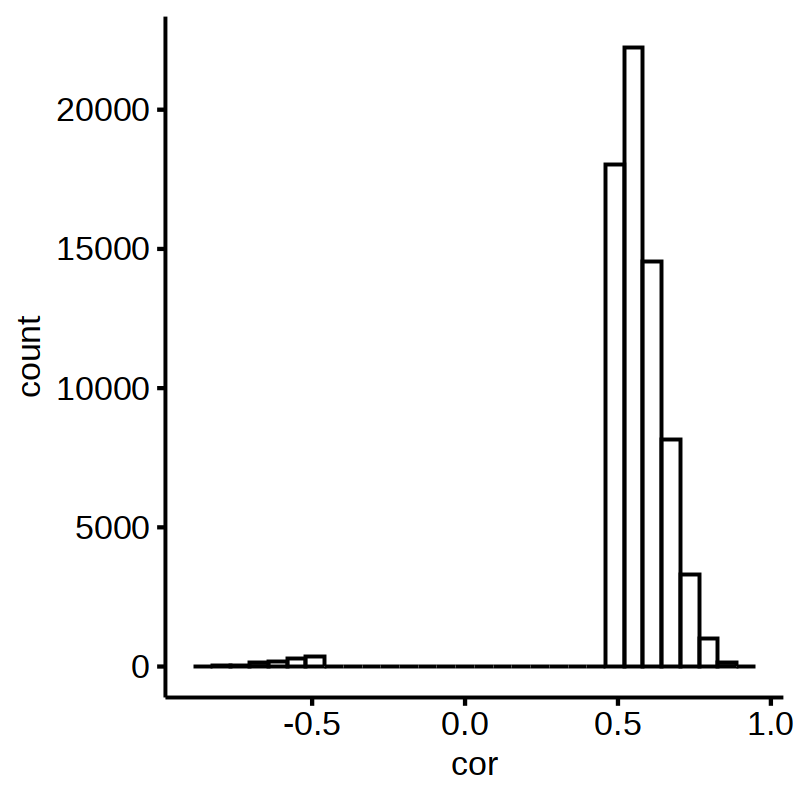

In [72]:
options(repr.plot.height = 4, repr.plot.width = 4,repr.plot.res = 200)
cor %>% filter(fdr < 0.05) %>% gghistogram("cor")

In [73]:
cor %>% mutate(cor = as.double(cor)) %>% filter(fdr < 0.05) %>% dim()

[1] 68458     5

## Random

In [74]:
gene <- di_link_gene$gene
pos <- di_link_gene$pos

results <- suppressWarnings(
  mapply(function(gene, pos) {
    RNA <- sctRNAmat_temp[[gene]]
    DI <- DI_dynamic_mc[[pos]]
    result <- cor_test_wrapper(gene, pos, RNA, DI, method = "random")
    result
  }, gene, pos, SIMPLIFY = FALSE)
)

results <- do.call(rbind, results)

In [75]:
cor_random <- results %>% as.data.frame() %>% rownames_to_column("V5") %>% select(-V5)
names(cor_random) <- c("gene","pos","cor","pvalue")

In [76]:
cor_random$fdr <- p.adjust(as.numeric(cor_random$pvalue), method = "BH")
cor_random %>% arrange(fdr)

gene,pos,cor,pvalue,fdr
<chr>,<chr>,<chr>,<chr>,<dbl>
B6-Glra2,8249_8292,0.968185179192387,0.000000000000000000539749325587282,0.0000000000001642646
B6-Glra2,8268_8303,0.968068227630585,0.000000000000000000568817790941828,0.0000000000001642646
B6-Plac1,2659_2709,0.961775821072881,0.000000000000000007415057342704,0.0000000000014275592
B6-Glra2,8254_8273,0.933162300774762,0.0000000000000203557355987037,0.0000000029391901078
B6-Bex2,6795_6825,0.92566154770626,0.0000000000000906231368636915,0.0000000104681504085
B6-Gm5127,5307_5322,0.923783152656952,0.000000000000128544618644447,0.0000000122605370743
B6-Mamld1,3548_3578,0.922251527254222,0.000000000000169823823456154,0.0000000122605370743
B6-Spin2c,7676_7733,0.922540938346215,0.000000000000161189128738577,0.0000000122605370743
B6-Spin2c,7707_7724,0.906992022397699,0.00000000000206548856489924,0.0000001325504336651


In [77]:
cor_random %>% write_tsv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/GADI_c5_res_new/c5_down_random_cor.tsv", col_names = TRUE)

In [77]:
compare <- rbind(cor %>% mutate(type = "GADI-gene"),cor_random %>% mutate(type="Random DI-gene"))
compare$cor <- as.numeric(compare$cor)


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor


Warning message:
"Removed 8730 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 8730 rows containing non-finite values (`stat_bin()`)."


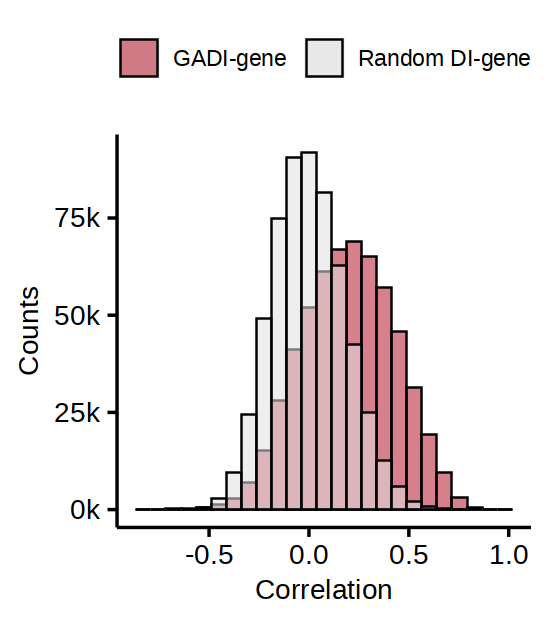

In [78]:
library(scales)

options(repr.plot.height = 2.5, repr.plot.width = 2.2,repr.plot.res = 250)
p <- compare %>% ggplot(aes(x=cor, fill = type, color = type)) +
  geom_histogram(color = "black",position="identity", alpha = 0.55, bins = 25, linewidth = 0.25) +
  scale_fill_manual(values = c("GADI-gene" = "#b2182b", "Random DI-gene" = "#e0e0e0")) +
    theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) + labs(fill = "") + xlab("Correlation") + ylab("Counts") + scale_y_continuous(labels = label_number(scale = 1e-3, suffix = "k"))
p 

ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3L_random_GADI_cor.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)

# Residual

In [79]:
calc_dynamic <-  function(gene, pos, sctRNAmat, di, pseudotime, correlation){
    RNA_temp <- sctRNAmat[,gene]
    if(correlation=="pos"){
        GADI_temp <- DI_dynamic_mc[,pos]
    }
    else{
        GADI_temp <- -DI_dynamic_mc[,pos]
    }
    tempData <- cbind(RNA_temp,pseudotime) %>% as.data.frame() 
    names(tempData) <- c("RNA","GADI","pseudotime")
    tempData <- tempData %>% gather(type,value,-pseudotime)
    tempData[is.na(tempData)] <- 0

    tempData <- tempData %>% group_by(type) %>% mutate(fitted_raw = predict(loess(value ~ pseudotime), se=T)$fit,fitted = (fitted_raw - min(fitted_raw))/(max(fitted_raw)-min(fitted_raw)),
                                          high = fitted + qt(0.975,predict(loess(value ~ pseudotime), se=T)$df)*predict(loess(value ~ pseudotime), se=T)$se, high = (high - min(high))/(max(high)-min(high)),
                                          low = fitted - qt(0.975,predict(loess(value ~ pseudotime), se=T)$df)*predict(loess(value ~ pseudotime), se=T)$se, low = (low - min(low))/(max(low)-min(low)))
    print("Running...")
    return(tempData %>% mutate(gene =gene,pos=pos))
}

In [83]:
gene <- "B6-1700111N16Rik"
pos <- "3500_3556"
RNA_temp <- sctRNAmat[metadata_mc %>% pull(cellname),gene]
GADI_temp <- DI_dynamic_mc[,pos]
pseudotime <- metadata_mc %>% pull(time1)

In [84]:
calc_dynamic <-  function(gene, pos, sctRNAmat, di, pseudotime, correlation){
    RNA_temp <- sctRNAmat[,gene]
    if(correlation=="pos"){
        GADI_temp <- DI_dynamic_mc[,pos]
    }
    else{
        GADI_temp <- -DI_dynamic_mc[,pos]
    }
    tempData <- cbind(RNA_temp,GADI_temp,pseudotime) %>% as.data.frame() 
    names(tempData) <- c("RNA","GADI","pseudotime")
    tempData <- tempData %>% gather(type,value,-pseudotime)
    tempData[is.na(tempData)] <- 0

    tempData <- tempData %>% group_by(type) %>% mutate(fitted_raw = predict(loess(value ~ pseudotime), se=T)$fit,fitted = (fitted_raw - min(fitted_raw))/(max(fitted_raw)-min(fitted_raw)),
                                          high = fitted + qt(0.975,predict(loess(value ~ pseudotime), se=T)$df)*predict(loess(value ~ pseudotime), se=T)$se, high = (high - min(high))/(max(high)-min(high)),
                                          low = fitted - qt(0.975,predict(loess(value ~ pseudotime), se=T)$df)*predict(loess(value ~ pseudotime), se=T)$se, low = (low - min(low))/(max(low)-min(low)))
    print("Running...")
    return(tempData %>% mutate(gene =gene,pos=pos))
}

In [85]:
head(calc_dynamic(gene = gene, pos = pos, sctRNAmat = sctRNAmat[metadata_mc %>% pull(cellname),], di = DI_dynamic_mc, pseudotime, correlation = "pos"))

[1] "Running..."


pseudotime,type,value,fitted_raw,fitted,high,low,gene,pos
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
4.766906,RNA,0,0.00010631538,0.13009380,0.13480678,0.12537809,B6-1700111N16Rik,3500_3556
9.828986,RNA,0,-0.00010932914,0.06426788,0.06510430,0.06343097,B6-1700111N16Rik,3500_3556
7.971831,RNA,0,-0.00003941594,0.08560902,0.08729655,0.08392052,B6-1700111N16Rik,3500_3556
18.308531,RNA,0,-0.00031986953,0.00000000,0.00000000,0.00000000,B6-1700111N16Rik,3500_3556
16.994350,RNA,0,-0.00026939960,0.01540605,0.01553422,0.01527780,B6-1700111N16Rik,3500_3556
14.711644,RNA,0,-0.00019824060,0.03712747,0.03748961,0.03676513,B6-1700111N16Rik,3500_3556


In [86]:
cor_residual <- cor %>% filter(fdr < 0.05)

In [87]:
dim(cor_residual)

[1] 68458     5

In [88]:
head(cor_residual)

,gene,pos,cor,pvalue,fdr
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,B6-1700111N16Rik,3500_3556,0.4984765,0.00431601092332749,0.041306702
2,B6-1700111N16Rik,3500_3560,0.6753038,0.0000307505106302112,0.002298459
3,B6-1700111N16Rik,3501_3556,0.5626023,0.000986015812463697,0.016925441
4,B6-1700111N16Rik,3501_3558,0.5265946,0.00234012055915692,0.028470519
5,B6-1700111N16Rik,3511_3556,0.5188335,0.00278528138143048,0.031663210
6,B6-1700111N16Rik,3511_3557,0.5479021,0.0014196393424452,0.021035515


In [89]:
start = Sys.time()
registerDoParallel(40)
B6Xi_neg <- foreach(gene = cor_residual %>% filter(cor < 0) %>% pull(gene), pos = cor_residual %>% filter(cor < 0) %>% pull(pos),.combine = "rbind", .errorhandling = "stop") %dopar% {
    calc_dynamic(gene,pos,sctRNAmat[metadata_mc %>% pull(cellname),],DI_dynamic_mc,pseudotime,correlation="neg") %>% mutate(gadi = paste0(pos,"_","neg"))
}
B6Xi_pos <- foreach(gene = cor_residual %>% filter(cor > 0) %>% pull(gene), pos = cor_residual %>% filter(cor > 0) %>% pull(pos),.combine = "rbind", .errorhandling = "stop") %dopar% {
        calc_dynamic(gene,pos,sctRNAmat[metadata_mc %>% pull(cellname),],DI_dynamic_mc,pseudotime,correlation="pos") %>% mutate(gadi = paste0(pos,"_","pos"))
}
residuals_dynamic <- rbind(B6Xi_neg,B6Xi_pos)
end = Sys.time()
end -start

Time difference of 17.1098 mins

In [90]:
fdr_threshold <- 0.05
temp <- residuals_dynamic %>%  group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
    select(-c(value,fitted_raw,fitted,high,low)) %>% group_by(type) %>% mutate(id = row_number()) %>% spread(type,norm_value)  %>% mutate(residual = GADI - RNA) %>% na.omit()  %>%
    group_by(gene,gadi) 
testres <- temp %>% group_by(gene,gadi) %>% summarise(residual = mean(GADI-RNA),pv = t.test(GADI-RNA,mu=0)$p.value,t=t.test(GADI-RNA,mu=0)$statistic) %>% ungroup()
#testres = temp %>% group_by(gene,gadi) %>% summarise(residual = mean(GADI-RNA),pv = wilcox.test(GADI-RNA,mu=0)$p.value,t=t.test(GADI-RNA,mu=0)$statistic) %>% ungroup()
testres <- testres  %>% mutate(fdr = p.adjust(pv,method="BH")) %>% 
    mutate(type = ifelse(sign(t)==1,"early","lag"),sigtype = ifelse(fdr < fdr_threshold,"sig","not")) 

`summarise()` has grouped output by 'gene'. You can override using the
`.groups` argument.


In [92]:
testres <- testres %>% mutate(start1 = str_split_fixed(gadi, "_", 3)[,1], start2 = str_split_fixed(gadi,"_",3)[,2], cor = str_split_fixed(gadi,"_",3)[,3])

In [93]:
head(testres)

gene,gadi,residual,pv,t,fdr,type,sigtype,start1,start2,cor
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
B6-1700111N16Rik,3500_3556_pos,-0.164299205,0.4829898,-0.710322632,0.7353134,lag,not,3500,3556,pos
B6-1700111N16Rik,3500_3560_pos,-0.114475098,0.5557704,-0.595810896,0.7850070,lag,not,3500,3560,pos
B6-1700111N16Rik,3501_3556_pos,0.002475133,0.9921424,0.009930552,0.9970799,early,not,3501,3556,pos
B6-1700111N16Rik,3501_3558_pos,-0.058973783,0.7892333,-0.269705638,0.9146507,lag,not,3501,3558,pos
B6-1700111N16Rik,3511_3556_pos,0.162361687,0.5244185,0.644078811,0.7637459,early,not,3511,3556,pos
B6-1700111N16Rik,3511_3557_pos,0.255901521,0.3337786,0.982361116,0.6100439,early,not,3511,3557,pos


In [94]:
total <- testres %>% dim()
posnum <- testres %>% filter(residual > 0) %>% dim()
negnum <- testres %>% filter(residual < 0) %>% dim()
print(paste0("Total Tested GADIs: ",total[1]))
print(paste0("Residual > 0 GADIs: ",posnum[1]))
print(paste0("Residual < 0 GADIs: ",negnum[1]))
print(paste0("Residual > 0 Ratio = ",posnum[1]/total[1]))

[1] "Total Tested GADIs: 68458"
[1] "Residual > 0 GADIs: 47001"
[1] "Residual < 0 GADIs: 21457"
[1] "Residual > 0 Ratio = 0.686566946156768"


In [95]:
testres %>% pull(gene) %>% unique() %>% length()

[1] 337

In [96]:
testres %>% group_by(sigtype) %>% summarise(count = n())

sigtype,count
<chr>,<int>
not,60866
sig,7592


In [97]:
testres %>% group_by(sigtype, type) %>% summarise(count = n())

`summarise()` has grouped output by 'sigtype'. You can override using the
`.groups` argument.


sigtype,type,count
<chr>,<chr>,<int>
not,early,39914
not,lag,20952
sig,early,7087
sig,lag,505


In [1]:
7087/68458

[1] 0.1035233

In [99]:
505/68458

[1] 0.007376786

In [100]:
testres %>% write_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/GADI_c5_res_new/c5_down_residual.csv')

In [4]:
testres <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/GADI_c5_res_new/c5_down_residual.csv")

Rows: 68458 Columns: 11
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (5): gene, gadi, type, sigtype, cor
dbl (6): residual, pv, t, fdr, start1, start2

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
testres %>% mutate(id = seq(1, nrow(.))) %>% filter(gene == "B6-Firre") %>% filter(start1 == 2535)

gene,gadi,residual,pv,t,fdr,type,sigtype,start1,start2,cor,id
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>
B6-Firre,2535_2542_pos,0.4100390,6.291146e-07,6.285717,0.0004147375,early,sig,2535,2542,pos,21247
B6-Firre,2535_2543_pos,0.4159100,2.157016e-07,6.673808,0.0002420737,early,sig,2535,2543,pos,21248
B6-Firre,2535_2544_pos,0.4284092,3.965798e-08,7.299122,0.0001148715,early,sig,2535,2544,pos,21249


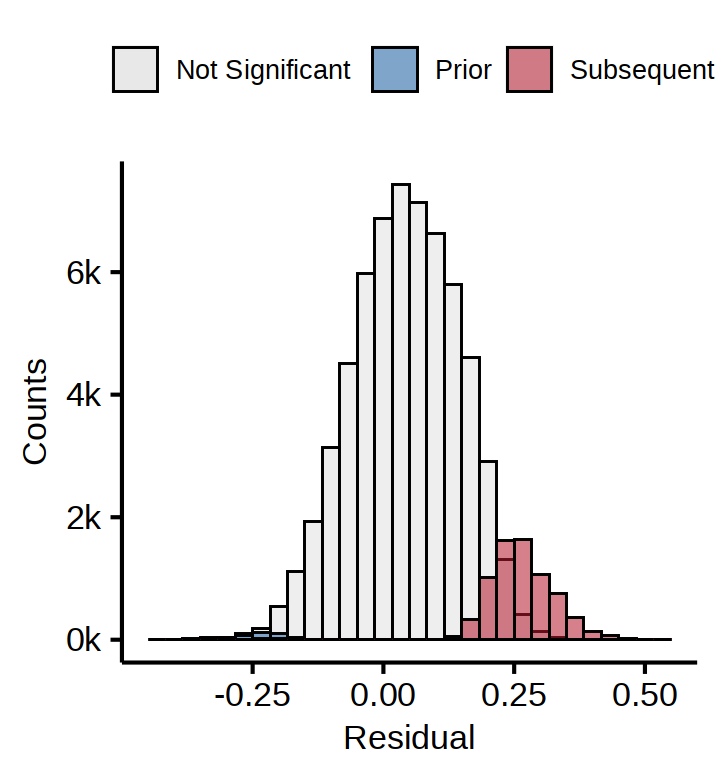

In [108]:
options(repr.plot.height = 2.6, repr.plot.width = 2.4,repr.plot.res = 300)
p <- testres %>% mutate(plot = ifelse(fdr >= 0.05, "Not Significant", ifelse(((cor == "pos")&(residual > 0))|((cor == "neg")&(residual < 0)), "Subsequent", "Prior"))) %>% 
    ggplot(aes(x=residual, fill = plot, color = plot)) +
  geom_histogram(color = "black",position="identity", alpha = 0.55, bins = 30, linewidth = 0.25) +
  scale_fill_manual(values = c("Prior" = "#2166ac", "Subsequent" = "#b2182b", "Not Significant" = "#e0e0e0")) +
    theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  )+ labs(fill = "") + xlab("Residual") + ylab("Counts") +scale_y_continuous(labels = label_number(scale = 1e-3, suffix = "k"))
p 

ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3M_prior_subsequent.svg", width = 2.4, height = 2.6, units = "in", dpi = 300)

In [104]:
testres %>% mutate(plot = ifelse(fdr >= 0.05, "Not Significant", ifelse(((cor == "pos")&(residual > 0))|((cor == "neg")&(residual < 0)), "Subsequent", "Prior"))) %>% 
    group_by(plot) %>% summarise(count = n())

plot,count
<chr>,<int>
Not Significant,60866
Prior,430
Subsequent,7162


# HiC↓ RNA↓

In [108]:
testres %>% filter(fdr < 0.05) %>% filter(cor == "pos") %>% filter(residual>0) %>% arrange(-residual) %>% head(100) %>% filter(gene == "B6-Firre")

gene,gadi,residual,pv,t,fdr,type,sigtype,start1,start2,cor
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
B6-Firre,2533_2540_pos,0.4582982,0.000000964603918,6.132007,0.00047972711,early,sig,2533,2540,pos
B6-Firre,2533_2541_pos,0.4462379,0.000000328571904,6.520643,0.00028659840,early,sig,2533,2541,pos
B6-Firre,2534_2544_pos,0.4323312,0.000000002066833,8.432888,0.00002644869,early,sig,2534,2544,pos
B6-Firre,2535_2544_pos,0.4284092,0.000000039657978,7.299122,0.00011487152,early,sig,2535,2544,pos
B6-Firre,2531_2538_pos,0.4182784,0.000000612264512,6.295503,0.00041473747,early,sig,2531,2538,pos
B6-Firre,2535_2543_pos,0.4159100,0.000000215701574,6.673808,0.00024207374,early,sig,2535,2543,pos


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


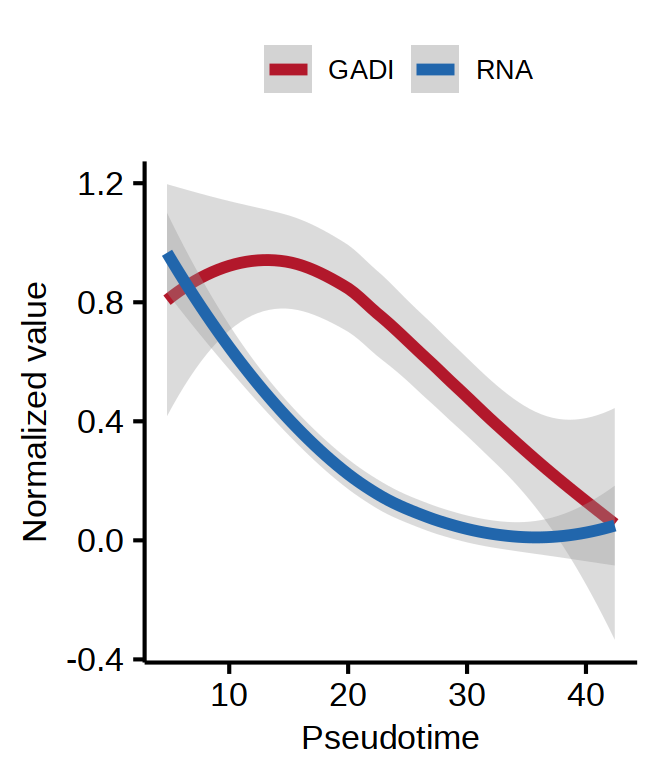

In [126]:
# Firre 2533_2544
options(repr.plot.width = 2.2,repr.plot.height=2.6,repr.plot.res= 300)
p <- residuals_dynamic %>% filter(gene == "B6-Firre" & pos == "2535_2544") %>% 
    group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
     select(-c(value,fitted_raw,fitted,high,low)) %>% 
    group_by(type)  %>% ggplot(aes(x=pseudotime,y=norm_value,color=type)) + 
    # geom_point(aes(group=type), size = 0.5, shape = 21) + 
    geom_smooth(aes(group=type), span = 1, alpha = 0.35) +
    ylab("Normalized value") +xlab("Pseudotime") + labs(color = "") +
    theme(legend.position = "top",
        text = element_text(family="Arial", size=8),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.line = element_line(color="black", linewidth = 0.35),
        axis.ticks = element_line(color="black", linewidth = 0.35),
        axis.text = element_text(color="black",size=8),
        legend.key = element_rect(colour = NA),
        legend.key.width = unit(0.4, "cm"),
        legend.key.height = unit(0.4, "cm"),
        axis.title=element_text(color="black",size=8,face="plain"),
) + scale_color_manual(values = c("#b2182b","#2166ac"))
p 
ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3N_example_GADI_RNA.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)